In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from fccd.util import limit_psd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
cu125 = pd.read_csv("../data/processed/cu_125.csv", index_col=0)
cu1000 = pd.read_csv("../data/processed/cu_1000.csv", index_col=0)
al125 = pd.read_csv("../data/processed/al_125.csv", index_col=0)
al1000 = pd.read_csv("../data/processed/al_1000.csv", index_col=0)
au125 = pd.read_csv("../data/processed/au_125.csv", index_col=0)
au1000 = pd.read_csv("../data/processed/au_1000.csv", index_col=0)

data = pd.concat([cu125, cu1000, al125, au1000, al1000, au125], axis=0)
data = data.reset_index(drop=True)


data["stress"] = data["stress"] * 1000
data["psd"] = data["psd"] * 1000

data["strain"] = data["strain"] * 100

# Limiting PSD to avoid bad splits

In some cases the PSD estimate lies above the max stress in a simulation. Since the dataset implementation can't deal with this, we need to limit the psd to the max stress in some way, that doesn't affect the quality of the results.

We take a look at examples where Movement-PSD > Max. Stress

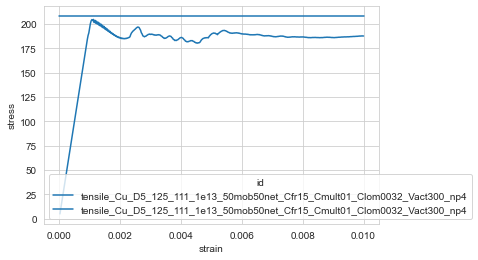

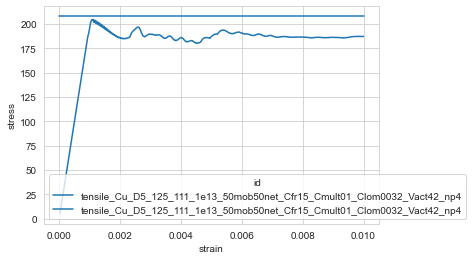

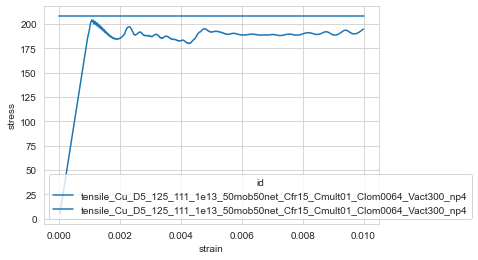

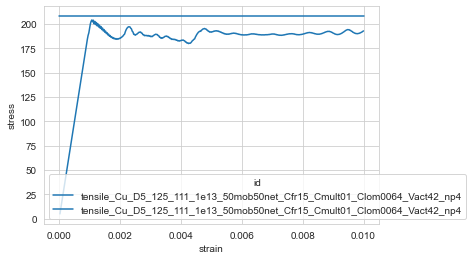

In [19]:
grouped = data.groupby("id").max("stress")
psd_too_high = grouped["stress"] < grouped["psd"]
idx = grouped[psd_too_high].reset_index()["id"]

no_plots = 10

for key in idx[:no_plots]:
    plot_data = data[data["id"] == key][["id", "stress", "psd", "strain"]]
    curve = sns.lineplot(data=plot_data, x="strain", y="stress", hue="id")
    psd = sns.lineplot(data=plot_data, x=np.linspace(0, 0.01, 400), y="psd", hue="id")
    psd.lines[2].set_linestyle("--")
    sns.move_legend(psd, loc="upper left", bbox_to_anchor=(1, 1))
    
    plt.xlabel("Strain in %", fontsize=15)
    plt.ylabel("Stress in MPa", fontsize=15)
    
    sns.set(font="Linux Libertine O")
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.savefig(f"{key}.pdf")
    plt.show()

We can take two things from the analysis. First, every example has a rho_total of 120 (see 1e13_50Mob50Net tag in legend), which is the largest number for this value. These very high estimates originate from high values for rho0, rho0_lomer and rho_S0.

Second, and more obvious in this graphics, is that the point of maximal stress tends not to be the last datapoint. We therefore limit the psd to the max stress - 1, which will enable to split the data at a decent point.

The limited PSD are shown below.

In [20]:
data = limit_psd(data)

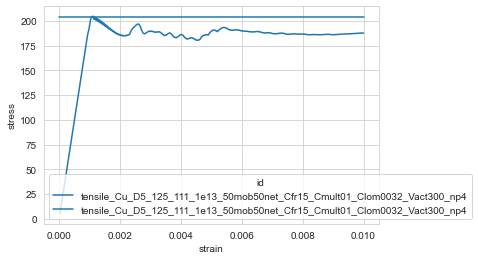

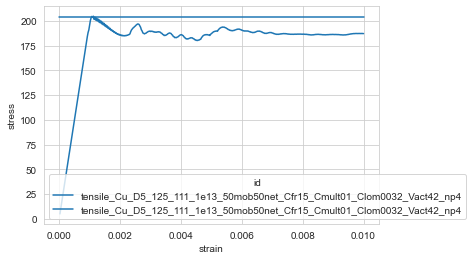

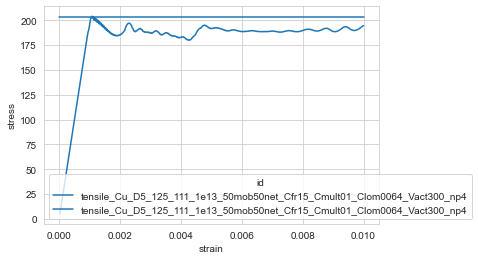

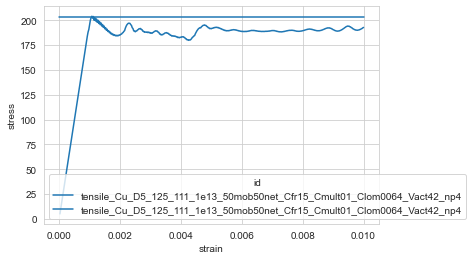

In [21]:
for key in idx[:no_plots]:
    plot_data = data[data["id"] == key][["id", "stress", "psd", "strain"]]
    sns.lineplot(data=plot_data, x="strain", y="stress", hue="id")
    sns.lineplot(data=plot_data, x=np.linspace(0, 0.01, 400), y="psd", hue="id")
    plt.show()